In [1]:
!pip install n2v

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 33.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.8/69.8 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 5.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import n2v
print(tf.__version__)
print(n2v.__version__)

2.14.0
0.3.3


In [3]:
from n2v.models import N2VConfig, N2V
import numpy as np
from csbdeep.utils import plot_history
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator
from matplotlib import pyplot as plt
import urllib
import os
import zipfile

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [4]:
datagen = N2V_DataGenerator()

In [5]:
imgs = datagen.load_imgs_from_directory(directory = "/content/",
                                        filter='*.tif',dims='YXC')  #ZYX for 3D

# Let's look at the shape of the image
print('shape of loaded images: ',imgs[0].shape)
# If the image has four color channels (stored in the last dimension): RGB and Aplha.
# We are not interested in Alpha and will get rid of it.
# imgs[0] = imgs[0][...,:3]
# print('shape without alpha:    ',imgs[0].shape)
# print('The data type of the first image is: ', imgs[0].dtype)

shape of loaded images:  (1, 256, 256, 3)


In [6]:
print(len(imgs))
print(imgs[0].shape)
print(imgs[0].dtype)

1
(1, 256, 256, 3)
float32


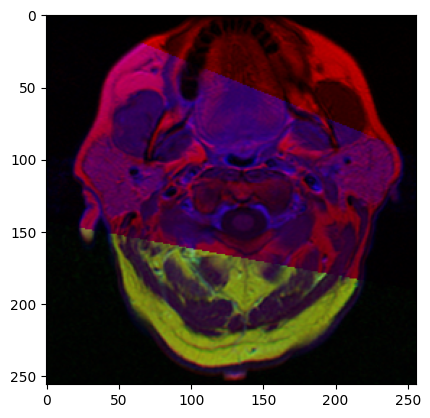

In [7]:
plt.figure()
plt.imshow(imgs[0][0, :, :, :3] / 255.0)  # Assuming pixel values are in [0, 255] range
plt.show()

In [8]:
patch_size = 64

In [9]:
# Patches are extracted from all images and combined into a single numpy array
patch_shape = (patch_size,patch_size)
patches = datagen.generate_patches_from_list(imgs, shape=patch_shape)

Generated patches: (128, 64, 64, 3)


In [10]:
patches.shape

(128, 64, 64, 3)

In [11]:
train_val_split = int(patches.shape[0] * 0.8)
X = patches[:train_val_split]
X_val = patches[train_val_split:]

In [12]:
print(X.shape)
print(X.dtype)
print(X_val.shape)

(102, 64, 64, 3)
float32
(26, 64, 64, 3)


In [13]:
datagen.generate_patches_from_list?

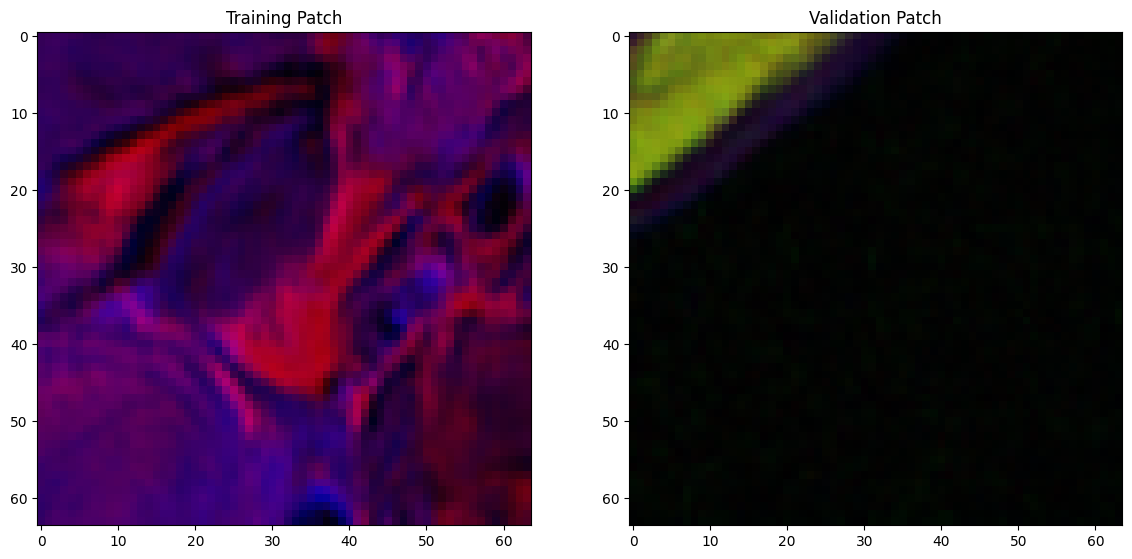

In [14]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.imshow(X[0, ...] / 255.0)  # Assuming pixel values are in [0, 255] range
plt.title('Training Patch')

plt.subplot(1, 2, 2)
plt.imshow(X_val[0, ...] / 255.0)  # Assuming pixel values are in [0, 255] range
plt.title('Validation Patch')

plt.show()

In [15]:
# train_steps_per_epoch is set to (number of training patches)/(batch size), like this each training patch
# is shown once per epoch.
train_batch = 32
config = N2VConfig(X, unet_kern_size=3,
                   unet_n_first=64, unet_n_depth=3, train_steps_per_epoch=int(X.shape[0]/train_batch), train_epochs=20, train_loss='mse',
                   batch_norm=True, train_batch_size=train_batch, n2v_perc_pix=0.198, n2v_patch_shape=(patch_size, patch_size),
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5, single_net_per_channel=False)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['50.434517', '13.759988', '31.209652'],
 'stds': ['46.9827', '36.248466', '33.917427'],
 'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 3,
 'n_channel_out': 3,
 'unet_residual': False,
 'unet_n_depth': 3,
 'unet_kern_size': 3,
 'unet_n_first': 64,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, 3),
 'train_loss': 'mse',
 'train_epochs': 20,
 'train_steps_per_epoch': 3,
 'train_learning_rate': 0.0004,
 'train_batch_size': 32,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': False,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [16]:
# a name used to identify the model --> change this to something sensible!
model_name = 'n2v_2D_mri'
# the base directory in which our model will live
basedir = 'models'
# We are now creating our network model.
model = N2V(config, model_name, basedir=basedir)

In [17]:
history = model.train(X, X_val)

8 blind-spots will be generated per training patch of size (64, 64).


Preparing validation data: 100%|██████████| 26/26 [00:00<00:00, 1067.19it/s]

Epoch 1/20


3/3 [==============================] - 37s 10s/step - loss: 1.1331 - n2v_mse: 1.1331 - n2v_abs: 0.8118 - val_loss: 0.9824 - val_n2v_mse: 0.9824 - val_n2v_abs: 0.7891 - lr: 4.0000e-04
Epoch 2/20
3/3 [==============================] - 30s 10s/step - loss: 0.5679 - n2v_mse: 0.5679 - n2v_abs: 0.5724 - val_loss: 0.9346 - val_n2v_mse: 0.9346 - val_n2v_abs: 0.7708 - lr: 4.0000e-04
Epoch 3/20
3/3 [==============================] - 29s 10s/step - loss: 0.3683 - n2v_mse: 0.3683 - n2v_abs: 0.4689 - val_loss: 0.8875 - val_n2v_mse: 0.8875 - val_n2v_abs: 0.7440 - lr: 4.0000e-04
Epoch 4/20
3/3 [==============================] - 30s 10s/step - loss: 0.2381 - n2v_mse: 0.2381 - n2v_abs: 0.3692 - val_loss: 0.8477 - val_n2v_mse: 0.8477 - val_n2v_abs: 0.7190 - lr: 4.0000e-04
Epoch 5/20
3/3 [==============================] - 29s 10s/step - loss: 0.1750 - n2v_mse: 0.1750 - n2v_abs: 0.3168 - val_loss: 0.8094 - val_n2v_mse: 0.8094 - val_n2v_abs: 0.6931 - lr: 4.0000e-04
Epoch 6/20
3/3 [=========================

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


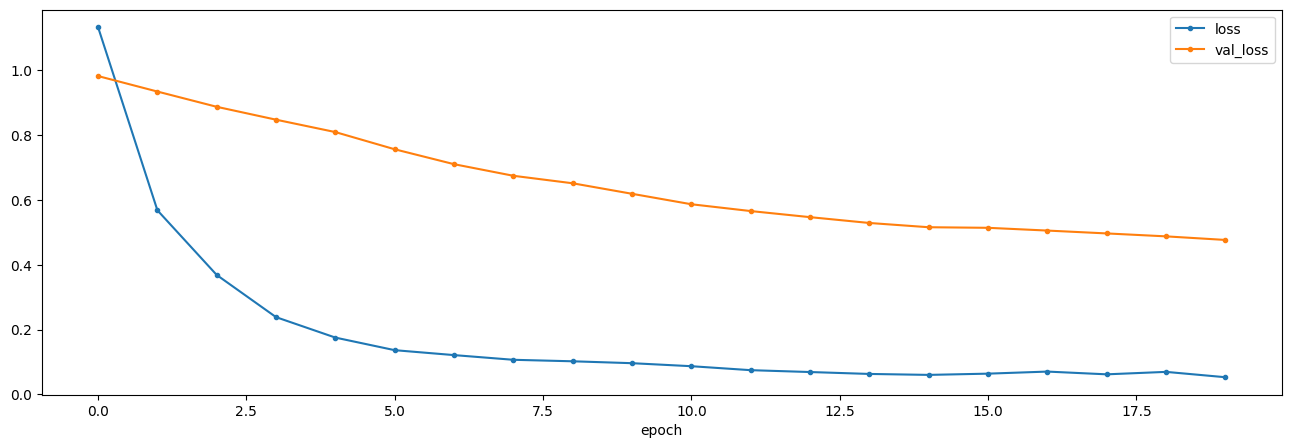

In [18]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plot_history(history,['loss','val_loss']);

**Denoising Image using Trained Model**

In [19]:
# We import all our dependencies.
from n2v.models import N2V
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.image import imread, imsave
from csbdeep.io import save_tiff_imagej_compatible

In [20]:
# A previously trained model is loaded by creating a new N2V-object without providing a 'config'.
model_name = 'n2v_2D_mri'
basedir = 'models'
model = N2V(config=None, name=model_name, basedir=basedir)

Loading network weights from 'weights_best.h5'.


In [24]:
from skimage.io import imread

# Load the image
img = imread('/content/TCGA_CS_4941_19960909_1.tif')

# Check the shape and data type of the image
print('Original image shape:', img.shape)
print('Original image data type:', img.dtype)

# If the image has four channels (RGBA), remove the alpha channel
if img.shape[2] == 4:
    img = img[:, :, :3]

# Check the new shape and data type after removing the alpha channel
print('Image shape without alpha:', img.shape)
print('Image data type without alpha:', img.dtype)


Original image shape: (256, 256, 3)
Original image data type: uint8
Image shape without alpha: (256, 256, 3)
Image data type without alpha: uint8


In [25]:
pred = model.predict(img, axes='YXC')

The input image is of type uint8 and will be casted to float32 for prediction.
1/1 [==============================] - 1s 1s/step


In [26]:
pred.shape

(256, 256, 3)

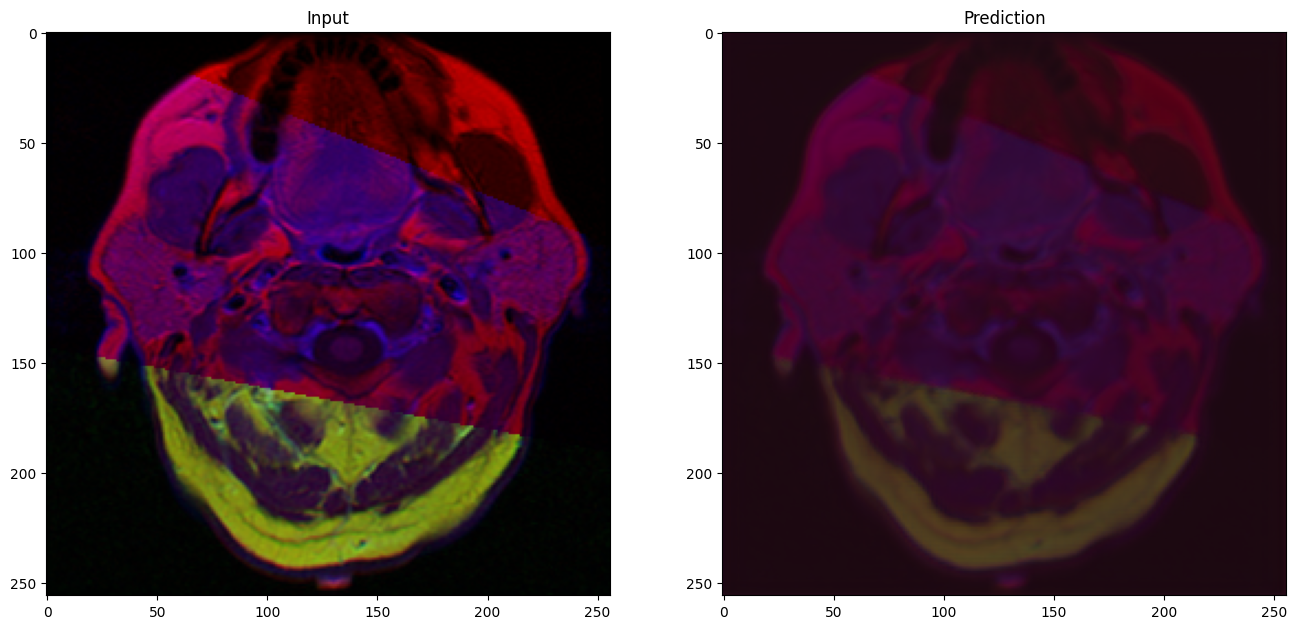

In [28]:
# Let's look at the results.
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(img / 255.0)  # Assuming pixel values are in [0, 255] range
plt.title('Input')

plt.subplot(1, 2, 2)
plt.imshow(pred / 255.0)  # Assuming pixel values are in [0, 255] range
plt.title('Prediction')

plt.show()